# Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных

Данные находятся в файле /datasets/autos.csv. Скачать датасет. 

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак

- Price — цена (евро)

## Подготовка данных

Установим требуемые библиотеки.

In [1]:
!pip install phik -q

In [2]:
!pip install imblearn -q

Выгрузим требуемые библиотеки.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import phik
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

Выгрузим датасет.

In [4]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('C:/Users/Student/Desktop/autos.csv')

Изучим датасет, посмотрев на данные датасета и общую информацию о нем.

In [5]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Датасет состоит из 16 столбцов:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

В столбцах есть пропущенные значения и непреобразованные типы данных.

Преобразуем типы данных столбцов 'DateCrawled', 'DateCreated', 'LastSeen' в datetime.

In [7]:
columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for column in columns:
    data[column] = pd.to_datetime(data[column], format='%Y.%m.%d %H:%M:%S')
data.loc[:,columns].describe(datetime_is_numeric=True)

,DateCrawled,DateCreated,LastSeen
count,354369,354369,354369
mean,2016-03-21 12:58:10.450648320,2016-03-20 19:12:07.753274112,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,2016-03-13 00:00:00,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2016-03-21 00:00:00,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,2016-03-29 00:00:00,2016-04-06 10:15:19
max,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


1. Столбцы DateCrawled и DateCreated имеют мало отличий, поэтому ставим только один столбец DateCreated.
2. DateCreated и LastSeen содержат данные за 2016 год (месяц март и апрель) и являются неинформативными.
3. Удалим DateCrawled, DateCreated, LastSeen, так как они являются неинформативными.

In [8]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

Проверим данные на выбросы и аномалии.

In [9]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Имеются аномалии в столбцах RegistrationYear, Power, Price и Created_minus_LastSeen_day, а также неинформативный столбец NumberOfPictures.

Удалим неинформативный столбец NumberOfPictures.

In [10]:
data = data.drop(['NumberOfPictures'], axis=1)

Удалим аномальные значения в стоблце RegistrationYear.

In [11]:
print((data['RegistrationYear'] > 2016).sum())
print((data['RegistrationYear'] < 1970).sum())
data = data.query('RegistrationYear >= 1970 & RegistrationYear < 2017')
data.shape

14530
1338


(338501, 12)

In [12]:
print((data['RegistrationMonth'] == 0).sum())
print(((data['RegistrationYear'] == 2016) & (data['RegistrationMonth'] > 4)).sum())
data = data.query('(RegistrationYear < 2016 | (RegistrationYear == 2016 & RegistrationMonth <= 4)) & RegistrationMonth > 0')
data.shape

33311
4690


(300500, 12)

Удалим аномальные значения в стоблце Power.

In [13]:
print((data['Power'] > 350).sum())
print((data['Power'] < 40).sum())
data = data.query('Power >= 40 & Power <= 350')
data.shape

1014
22222


(277264, 12)

Удалим аномальные значения в столбце Price.

In [14]:
print((data['Price'] < 50).sum())
data = data.query('Price >= 50')
data.shape

4888


(272376, 12)

Построим гистограммы для всех столбцов датасета.

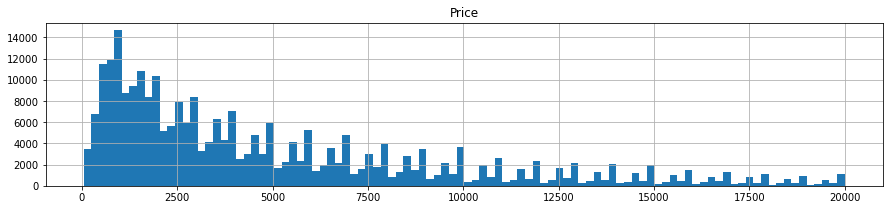

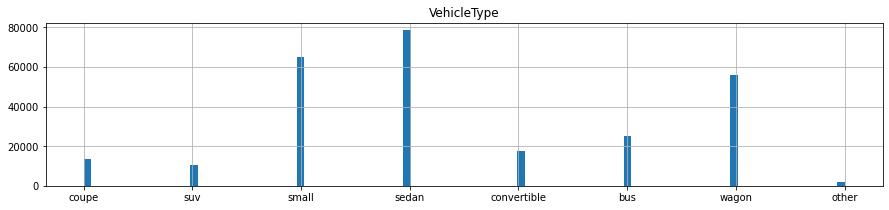

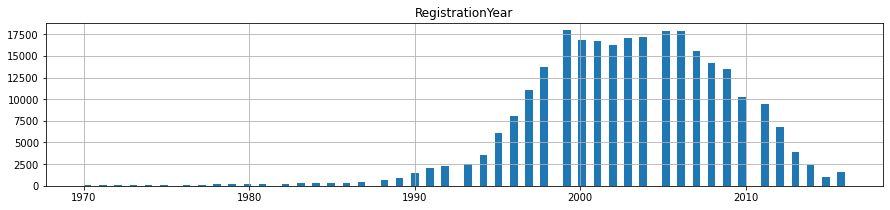

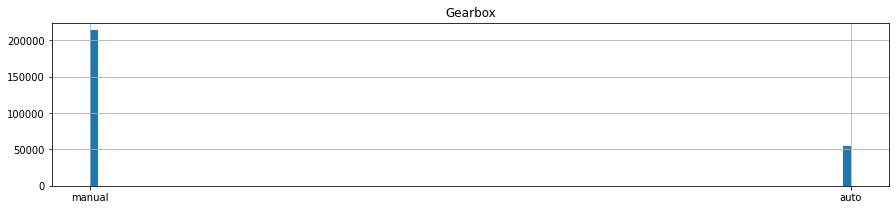

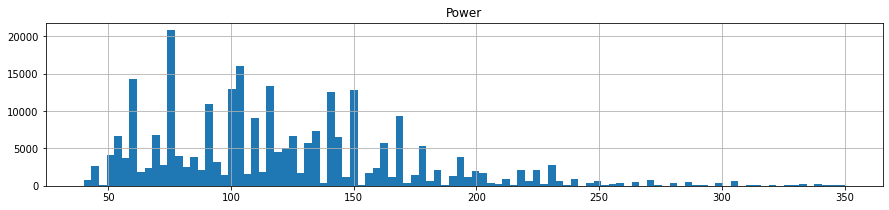

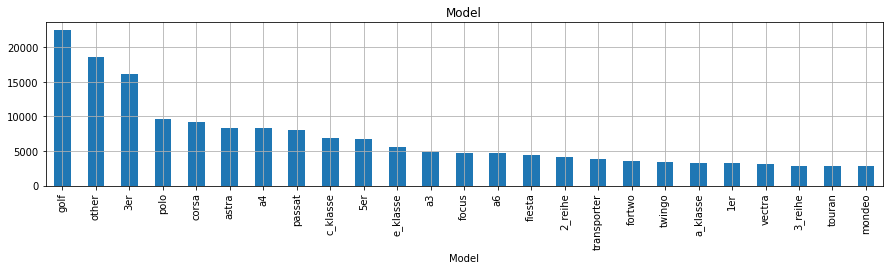

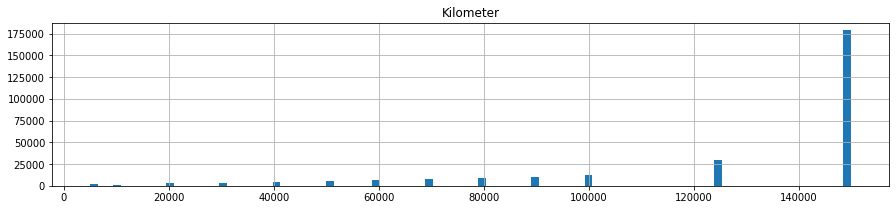

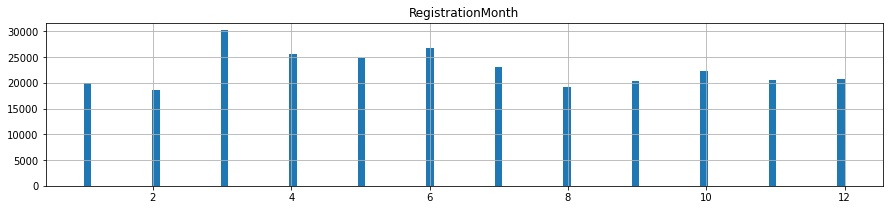

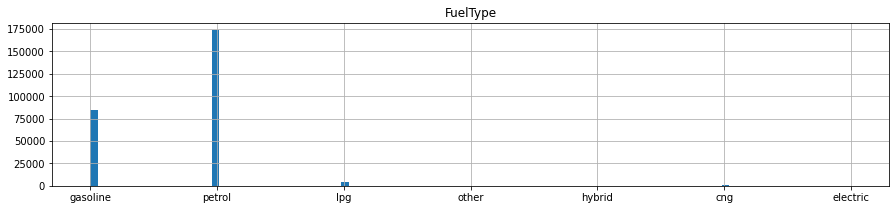

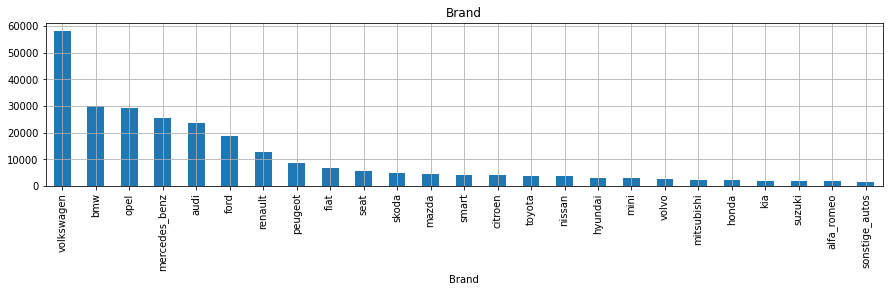

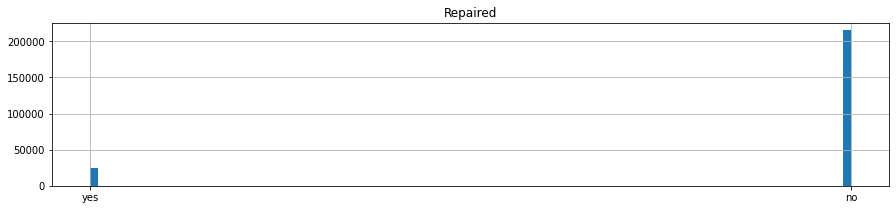

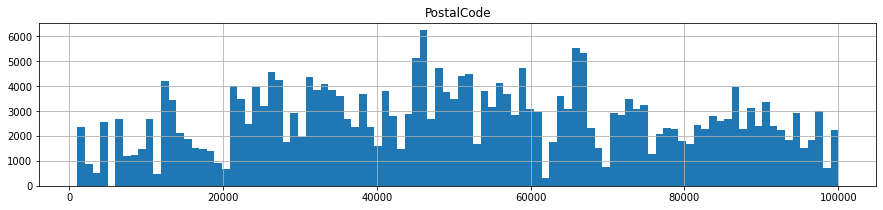

In [15]:
for c in data.columns:
    plt.title(c)
    if data[c].dtype == 'object':
        if len(data[c].unique()) > 25:
            data.groupby(c)[c].count().sort_values(ascending=False).head(25).plot(kind='bar', figsize=(15,3), grid=True);
        else:
            data[c].hist(bins=100, figsize=(15,3));
    else:
            data[c].hist(bins=100, figsize=(15,3));
    plt.show()

1. Чаще всего встречается значения цены до 2500 евро. С увеличением цены, уменьшается количество выставленных на продажу автомобилей.
2. Седан чаще всего выставлются на продажу.
3. Машины начала 2000-х чаще всего выставляются на продажу.
4. Автомобили с механической КПП встречаются чаще чем с автоматической КПП.
5. Мощность автомобилей около 75 л.с. преобладают среди объявлений. Чем выше мощность, тем реже встречаются автомобили.
6. Golf - самая популярная модель автомобиля.
7. Чем больше пробег автомобиля, тем чаще его можно встретить в объявлениях.
8. В марте приходился пик регистраций автомобилей, а в феврале это делали реже всего.
9. Бензиновые двигатели встречаются чаще всего среди объявлений.
10. Wolkswagen - самый популярный бренд.
11. Чаще всего автомобили не были в ремонте.

Столбец PostalCode и RegistrationMonth имеет низкую информативность, поэтому удалим их.

In [16]:
data = data.drop(['PostalCode', 'RegistrationMonth'], axis=1)

Сгруппируем 'gasoline' и 'petrol' в столбце FuelType.

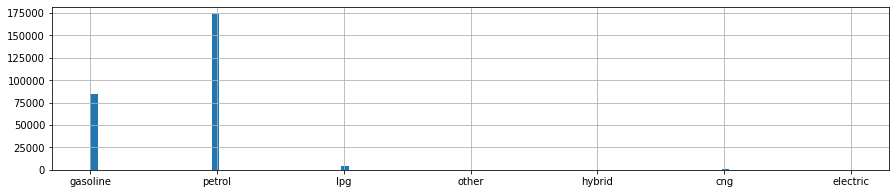

In [17]:
data['FuelType'].hist(bins=100, figsize=(15,3));

In [18]:
data.loc[data['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

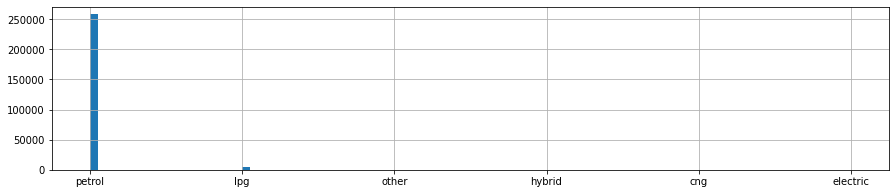

In [19]:
data['FuelType'].hist(bins=100, figsize=(15,3));

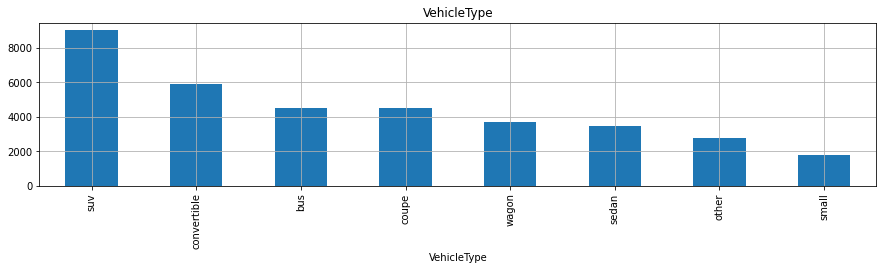

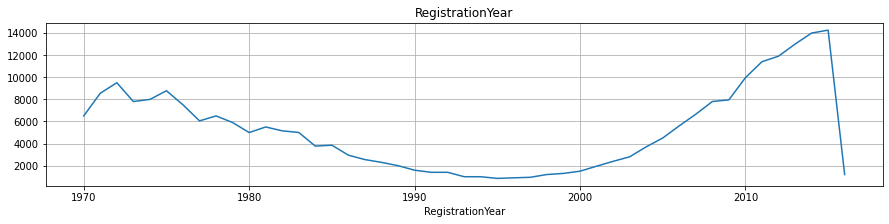

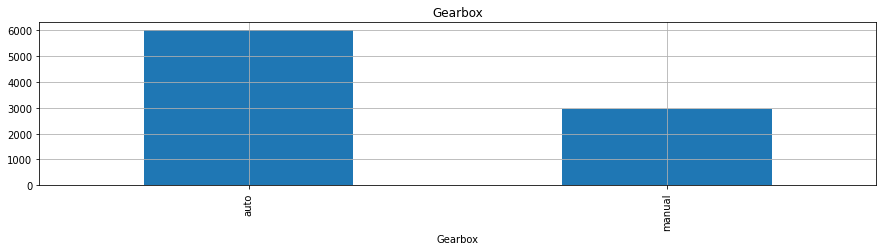

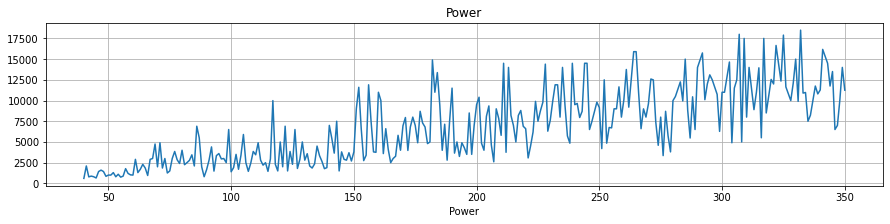

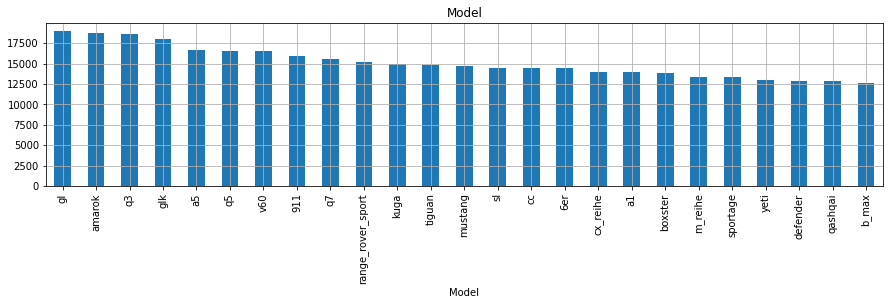

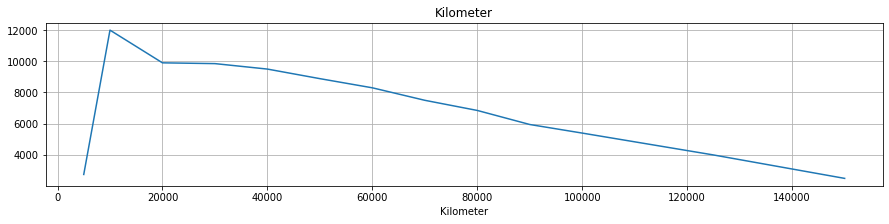

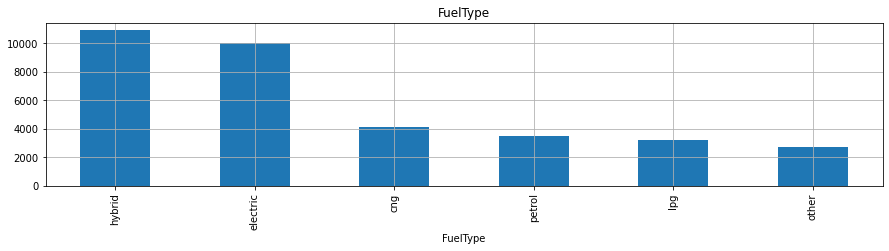

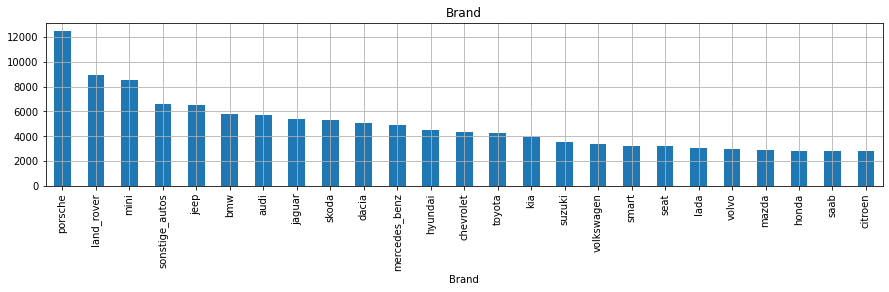

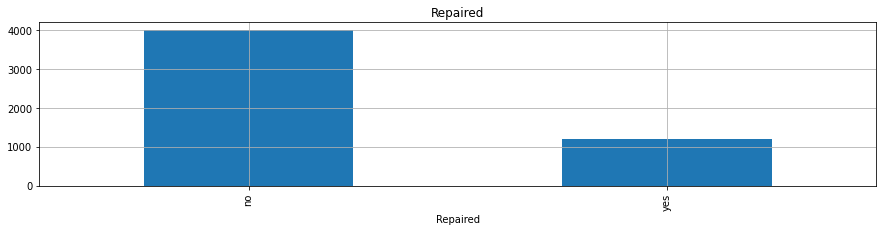

In [20]:
for c in data.drop(['Price'], axis=1).columns:
    plt.title(c)
    if data[c].dtype == 'object':
        data.groupby(c)['Price'].median().sort_values(ascending=False).head(25).plot(kind='bar', figsize=(15,3), grid=True);
    else:
        data.groupby(c)['Price'].median().plot(figsize=(15,3), grid=True);
    plt.show()

1. Кроссовер - самый дорогой тип кузова, маленький кузов - самый дешевый.
2. Автомобили недавненего года выпуска - самые дорогие. Автомобили, которые были выпущены в 70-х стоять тоже достаточно дорого так, как, видимо, становятся раритетными.
3. Автомат стоит дороже механики.
4. Чем выше мощность автомобиля, тем больше стоимость.
5. Gl - самая дорогая модель.
6. Чем больше километров пробега, тем ниже стоимость.
7. Месяц регистрации автомобиля не зависит от стоимости.
8. Гибридные автомобили - самые дорогие.
9. Порше - самый дорогой бренд.
10. Автомобили без ремонта стоят дороже.

Построим матрицу корреляции.

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


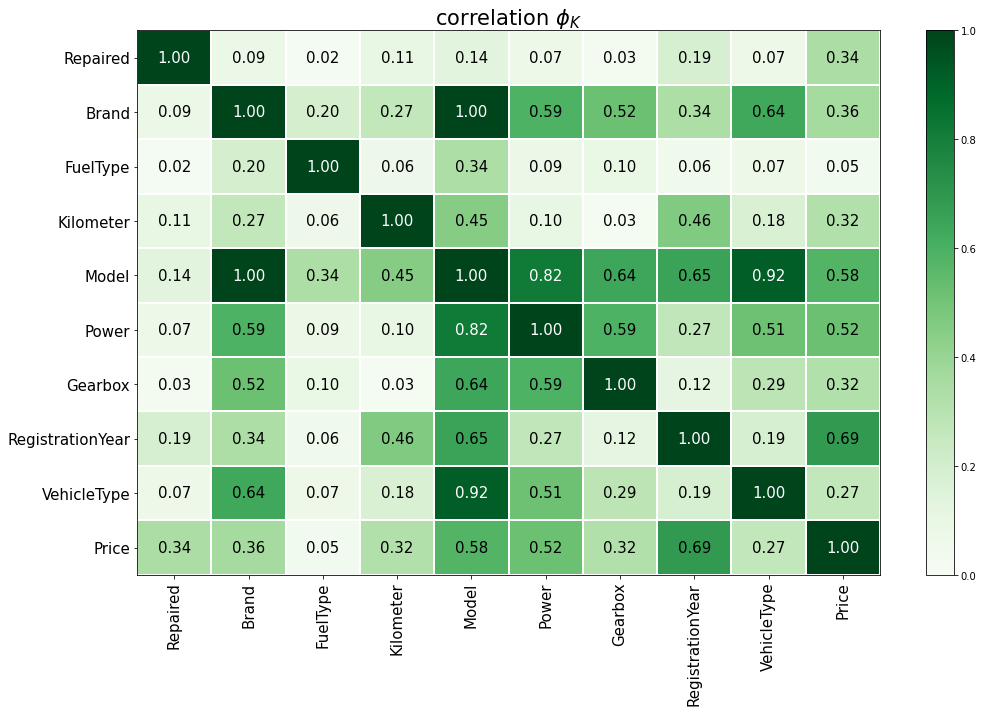

In [21]:
phic_matr = data.phik_matrix()
plot_correlation_matrix(phic_matr.values, 
                        x_labels=phic_matr.columns, 
                        y_labels=phic_matr.index, 
                        vmin=0, 
                        vmax=1, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

Как видно из матрицы Beand и Model полностью коррелируют и один из этих столбцов может быть убран из датасета. Сильная корреляция заметна у стоблцов Model и VehicleType и равняется 0.92.

In [20]:
data = data.drop(['PostalCode', 'RegistrationMonth'], axis=1)

Посмотрим количество пропущенных значений.

In [22]:
data.isna().sum()

Price                   0
VehicleType          4132
RegistrationYear        0
Gearbox              3500
Power                   0
Model                8126
Kilometer               0
FuelType             9478
Brand                   0
Repaired            32290
dtype: int64

Пропущенные значения имеются в столбцах VehicleType, Gearbox, Power, Model, FuelType, Repaired.

Создадим функцию заполнения пропущенных значений самым популярным значением из этого же столбца по общей категории.

In [23]:
def func_pass(column_pass, column_not_pass):
    for t in data[column_not_pass].unique():
        try:
            data.loc[(data[column_not_pass] == t) & (data[column_pass].isna()), column_pass] = \
            data.loc[(data[column_not_pass] == t), column_pass].mode()[0]
        except:
            data.loc[(data[column_not_pass] == t) & (data[column_pass].isna()), column_pass] = 'unknown'

1. 'Model' и 'Brand' имеют зависимость. Заполним пропуски в столбце 'Model' по категориям из столбца 'Brand'.
2. 'VehicleType', 'Gearbox', 'FuelType' имеют завимость от столбца 'Model'. Заполним пропуски в данных столбцах по категориям из столбца 'Model'.

In [24]:
func_pass('Model', 'Brand')
columns_pass = ['VehicleType', 'Gearbox', 'FuelType']
for column_pass in columns_pass:
    func_pass(column_pass, 'Model')

Заполним пропуски в 'Repaired' значением 'unknown'.

In [25]:
data['Repaired'] = data['Repaired'].fillna('unknown')

Проверим, заполнили ли мы пропуски.

In [26]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Проверим количество дубликатов.

In [27]:
print(('Количество дубликатов: {0}').format(data.duplicated().sum()))

Количество дубликатов: 39946


Удалим дубликаты.

In [28]:
data = data.drop_duplicates()
data.shape

(232430, 10)

Построим еще раз матрицу корреляции, чтобы посомтреть как после изменений коррелируют модели и брэнды.

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


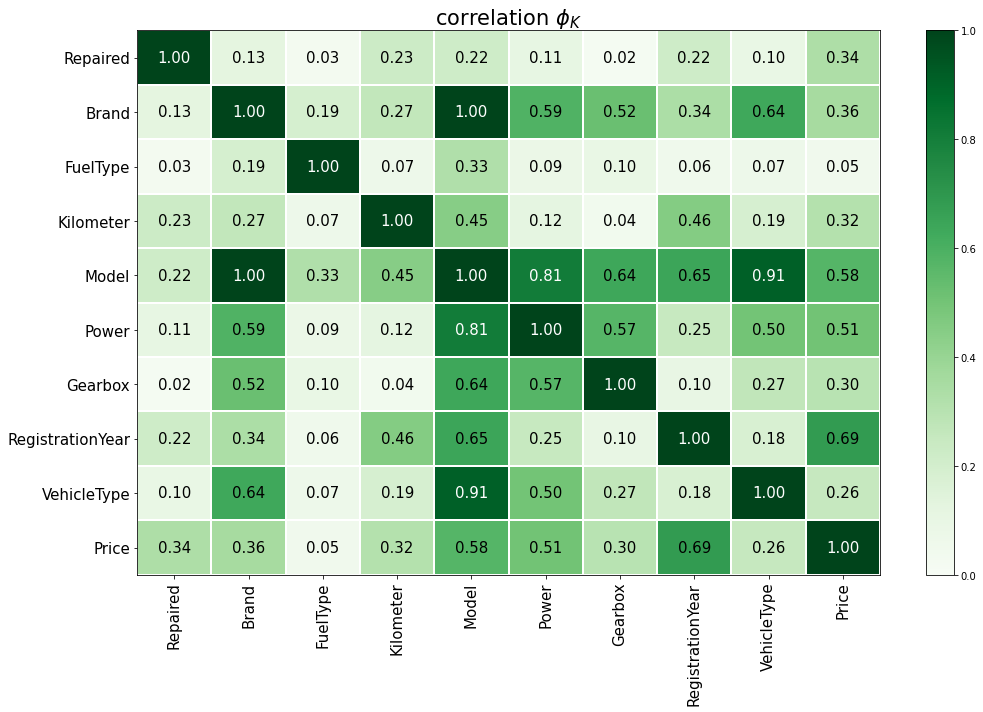

In [29]:
phic_matr = data.phik_matrix()
plot_correlation_matrix(phic_matr.values, 
                        x_labels=phic_matr.columns, 
                        y_labels=phic_matr.index, 
                        vmin=0, 
                        vmax=1, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

Удалим столбец Brand, который полностью коррелирует со столбцом Model.

In [30]:
data = data.drop(['Brand'], axis=1)

## Обучение моделей

Разделим датасет на обучающие признаки и на целевой признак.

In [31]:
features = data.drop(['Price'], axis=1)
target = data['Price']

При помощи pipeline и column_transformer соберем свой конвейер, включающий:
1. Для численных столбцов масштабирование данных при помощи StandardScaler().
2. Для категориальных столбцов кодирование данных при помощи OneHotEncoder().

In [36]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Kilometer']
num_columns = ['Power', 'RegistrationYear']

In [37]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
column_transformer = make_column_transformer((num_pipeline, num_columns),
                                             (cat_pipeline, cat_columns))

Разделим выборку на обучающую и тестовую

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,  
                                                                            test_size=0.25, 
                                                                            random_state=12345)
print(features_train.shape)
print(features_test.shape)

(174322, 8)
(58108, 8)


Обучим модель RandomForestRegressor() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров max_depth и n_estimators.

In [42]:
%%time
pipeline_rfr = make_pipeline(column_transformer,  RandomForestRegressor(random_state=13))
params = {
    'max_depth': [10,20,30],
    'n_estimators': [10,20]
    }
new_params = {'randomforestregressor__' + key: params[key] for key in params}
grid_rfr = GridSearchCV(pipeline_rfr, 
                             param_grid=new_params,
                             verbose=0,
                             cv=3, 
                             scoring='neg_root_mean_squared_error', 
                             n_jobs=-1)
grid_rfr.fit(features_train, target_train)
print(grid_rfr.best_params_)
print(grid_rfr.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=10;, score=-1954.880 total time=  19.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=10;, score=-1955.058 total time=  19.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=10;, score=-1962.836 total time=  19.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=20;, score=-1947.016 total time=  38.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=20;, score=-1948.494 total time=  37.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=20;, score=-1953.581 total time=  40.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END randomforestregressor__max_depth=20, randomforestregressor__n_estimators=10;, score=-1767.030 total time=  23.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END randomforestregressor__max_depth=20, randomforestregressor__n_estimators=10;, score=-1760.089 total time=  23.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END randomforestregressor__max_depth=20, randomforestregressor__n_estimators=10;, score=-1769.996 total time=  23.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END randomforestregressor__max_depth=20, randomforestregressor__n_estimators=20;, score=-1748.430 total time=  46.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END randomforestregressor__max_depth=20, randomforestregressor__n_estimators=20;, score=-1743.439 total time=  47.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END randomforestregressor__max_depth=20, randomforestregressor__n_estimators=20;, score=-1751.447 total time=  46.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END randomforestregressor__max_depth=30, randomforestregressor__n_estimators=10;, score=-1750.236 total time=  25.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END randomforestregressor__max_depth=30, randomforestregressor__n_estimators=10;, score=-1751.945 total time=  24.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END randomforestregressor__max_depth=30, randomforestregressor__n_estimators=10;, score=-1761.184 total time=  24.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END randomforestregressor__max_depth=30, randomforestregressor__n_estimators=20;, score=-1728.435 total time=  49.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END randomforestregressor__max_depth=30, randomforestregressor__n_estimators=20;, score=-1727.807 total time=  47.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END randomforestregressor__max_depth=30, randomforestregressor__n_estimators=20;, score=-1737.413 total time=  47.4s
{'randomforestregressor__max_depth': 30, 'randomforestregressor__n_estimators': 20}
-1731.2184395739387
CPU times: user 11min 7s, sys: 11.4 s, total: 11min 19s
Wall time: 11min 21s


Лучшие параметры:

- max_depth = 30
- n_estimators = 20

RMSE = 1731

Обучим модель LGBMRegressor() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров learning_rate и n_estimators.

In [43]:
%%time
pipeline = make_pipeline(column_transformer, lgb.LGBMRegressor(objective='regression', random_state=13))
params = {
    'learning_rate': [0.1,0.5],
     'n_estimators': [20,40]
}
new_params = {'lgbmregressor__' + key: params[key] for key in params}
grid_imba_lgb = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             verbose=0,
                             cv=3, 
                             scoring='neg_root_mean_squared_error', 
                             n_jobs=-1)
grid_imba_lgb.fit(features_train, target_train)
print(grid_imba_lgb.best_params_)
print(grid_imba_lgb.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmregressor__learning_rate=0.1, lgbmregressor__n_estimators=20;, score=-2114.770 total time= 1.8min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END lgbmregressor__learning_rate=0.1, lgbmregressor__n_estimators=20;, score=-2123.242 total time= 1.7min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmregressor__learning_rate=0.1, lgbmregressor__n_estimators=20;, score=-2127.360 total time= 1.8min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmregressor__learning_rate=0.1, lgbmregressor__n_estimators=40;, score=-1868.460 total time= 2.6min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END lgbmregressor__learning_rate=0.1, lgbmregressor__n_estimators=40;, score=-1878.377 total time= 2.6min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmregressor__learning_rate=0.1, lgbmregressor__n_estimators=40;, score=-1872.642 total time= 2.6min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmregressor__learning_rate=0.5, lgbmregressor__n_estimators=20;, score=-1760.563 total time= 1.2min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END lgbmregressor__learning_rate=0.5, lgbmregressor__n_estimators=20;, score=-1783.041 total time= 1.6min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmregressor__learning_rate=0.5, lgbmregressor__n_estimators=20;, score=-1775.709 total time= 1.3min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmregressor__learning_rate=0.5, lgbmregressor__n_estimators=40;, score=-1707.385 total time= 2.1min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END lgbmregressor__learning_rate=0.5, lgbmregressor__n_estimators=40;, score=-1727.348 total time= 2.5min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmregressor__learning_rate=0.5, lgbmregressor__n_estimators=40;, score=-1717.404 total time= 3.1min
{'lgbmregressor__learning_rate': 0.5, 'lgbmregressor__n_estimators': 40}
-1717.3789586308133
CPU times: user 27min 15s, sys: 22.6 s, total: 27min 37s
Wall time: 27min 51s


Лучшие параметры:

- n_estimators = 40
- learning_rate = 0.5

RMSE = 1717

Обучим модель CatBoostRegressor() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров learning_rate и depth.

In [44]:
%%time
pipeline = make_pipeline(column_transformer, CatBoostRegressor(random_state=13))
params = {'depth'         : [4,6],
          'learning_rate' : [0.01,0.1,0.2],
         }
new_params = {'catboostregressor__' + key: params[key] for key in params}
grid_imba_cbr = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             cv=3, 
                             scoring='neg_root_mean_squared_error',
                             verbose=0,
                             n_jobs=-1)
grid_imba_cbr.fit(features_train, target_train)
print(grid_imba_cbr.best_params_)
print(grid_imba_cbr.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 4664.8832933	total: 62.3ms	remaining: 1m 2s
1:	learn: 4635.3544962	total: 74.7ms	remaining: 37.3s
2:	learn: 4607.2664467	total: 86.9ms	remaining: 28.9s
3:	learn: 4579.2701783	total: 102ms	remaining: 25.5s
4:	learn: 4551.4556163	total: 115ms	remaining: 22.8s
5:	learn: 4523.6588489	total: 127ms	remaining: 21.1s
6:	learn: 4496.0015186	total: 139ms	remaining: 19.7s
7:	learn: 4468.8520215	total: 151ms	remaining: 18.7s
8:	learn: 4441.9090966	total: 163ms	remaining: 18s
9:	learn: 4415.3280792	total: 176ms	remaining: 17.4s
10:	learn: 4389.5441343	total: 191ms	remaining: 17.2s
11:	learn: 4364.2151177	total: 205ms	remaining: 16.9s
12:	learn: 4339.0418190	total: 217ms	remaining: 16.4s
13:	learn: 4314.5372684	total: 229ms	remaining: 16.1s
14:	learn: 4289.8356065	total: 241ms	remaining: 15.8s
15:	learn: 4265.3025449	total: 259ms	remaining: 15.9s
16:	learn: 4241.5892827	total: 274ms	remaining: 15.8s
17:	learn: 4216.9733207	total: 

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.01;, score=-1978.265 total time=  29.9s
0:	learn: 4664.9372748	total: 12.2ms	remaining: 12.1s
1:	learn: 4635.4137070	total: 23.9ms	remaining: 11.9s
2:	learn: 4607.4082798	total: 36.2ms	remaining: 12s
3:	learn: 4579.6989237	total: 54.2ms	remaining: 13.5s
4:	learn: 4551.8154458	total: 66.4ms	remaining: 13.2s
5:	learn: 4523.9913486	total: 78.8ms	remaining: 13.1s
6:	learn: 4496.2926189	total: 90.9ms	remaining: 12.9s
7:	learn: 4469.1856376	total: 104ms	remaining: 12.8s
8:	learn: 4442.7349611	total: 116ms	remaining: 12.7s
9:	learn: 4416.9386832	total: 128ms	remaining: 12.7s
10:	learn: 4391.1756269	total: 144ms	remaining: 12.9s
11:	learn: 4365.9140759	total: 156ms	remaining: 12.9s
12:	learn: 4340.5726382	total: 173ms	remaining: 13.1s
13:	learn: 4315.1077524	total: 191ms	remaining: 13.4s
14:	learn: 4290.3375864	total: 209ms	remaining: 13.7s
15:	learn: 4265.8386688	total: 227ms	remaining: 14s
16:	learn: 4242.0710509	tot

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.01;, score=-1981.146 total time=  29.2s
0:	learn: 4654.6537595	total: 14.9ms	remaining: 14.9s
1:	learn: 4625.1919389	total: 32.2ms	remaining: 16.1s
2:	learn: 4597.3287845	total: 48.9ms	remaining: 16.3s
3:	learn: 4568.5839636	total: 63.7ms	remaining: 15.9s
4:	learn: 4540.8651645	total: 76.9ms	remaining: 15.3s
5:	learn: 4513.2028209	total: 90.7ms	remaining: 15s
6:	learn: 4485.6536913	total: 107ms	remaining: 15.2s
7:	learn: 4458.4614609	total: 121ms	remaining: 15.1s
8:	learn: 4431.6334260	total: 134ms	remaining: 14.7s
9:	learn: 4405.8889211	total: 146ms	remaining: 14.5s
10:	learn: 4380.2050131	total: 159ms	remaining: 14.3s
11:	learn: 4354.9912566	total: 171ms	remaining: 14.1s
12:	learn: 4329.8906447	total: 184ms	remaining: 13.9s
13:	learn: 4304.8918592	total: 198ms	remaining: 14s
14:	learn: 4280.1853273	total: 214ms	remaining: 14.1s
15:	learn: 4256.0541630	total: 227ms	remaining: 13.9s
16:	learn: 4232.2983165	tota

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.01;, score=-1982.493 total time=  29.1s
0:	learn: 4401.8818791	total: 19.4ms	remaining: 19.4s
1:	learn: 4147.7628587	total: 37.3ms	remaining: 18.6s
2:	learn: 3923.8129021	total: 49.9ms	remaining: 16.6s
3:	learn: 3732.6069414	total: 62.4ms	remaining: 15.5s
4:	learn: 3559.2452766	total: 75.4ms	remaining: 15s
5:	learn: 3401.4288046	total: 88.4ms	remaining: 14.6s
6:	learn: 3265.5292642	total: 102ms	remaining: 14.4s
7:	learn: 3153.4923940	total: 114ms	remaining: 14.2s
8:	learn: 3045.8953967	total: 127ms	remaining: 14s
9:	learn: 2953.3934596	total: 141ms	remaining: 13.9s
10:	learn: 2871.2473795	total: 154ms	remaining: 13.9s
11:	learn: 2800.8443258	total: 168ms	remaining: 13.8s
12:	learn: 2737.5173577	total: 181ms	remaining: 13.7s
13:	learn: 2680.7592508	total: 194ms	remaining: 13.6s
14:	learn: 2633.1072225	total: 207ms	remaining: 13.6s
15:	learn: 2589.6993614	total: 220ms	remaining: 13.5s
16:	learn: 2551.6827717	tota

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.1;, score=-1700.310 total time=  31.1s
0:	learn: 4406.7670417	total: 12.8ms	remaining: 12.8s
1:	learn: 4149.2680921	total: 25.4ms	remaining: 12.7s
2:	learn: 3927.4260298	total: 38.3ms	remaining: 12.7s
3:	learn: 3728.2134557	total: 51.5ms	remaining: 12.8s
4:	learn: 3556.4021496	total: 66.9ms	remaining: 13.3s
5:	learn: 3400.5830586	total: 81.1ms	remaining: 13.4s
6:	learn: 3262.3884753	total: 101ms	remaining: 14.4s
7:	learn: 3146.8370826	total: 121ms	remaining: 15s
8:	learn: 3039.0944981	total: 141ms	remaining: 15.5s
9:	learn: 2950.7838739	total: 155ms	remaining: 15.4s
10:	learn: 2872.2319638	total: 168ms	remaining: 15.1s
11:	learn: 2797.2748414	total: 180ms	remaining: 14.8s
12:	learn: 2733.8104246	total: 193ms	remaining: 14.7s
13:	learn: 2676.8864816	total: 206ms	remaining: 14.5s
14:	learn: 2625.8308526	total: 219ms	remaining: 14.4s
15:	learn: 2582.2135664	total: 234ms	remaining: 14.4s
16:	learn: 2542.2706732	tot

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.1;, score=-1708.138 total time=  29.0s
0:	learn: 4397.4685747	total: 13.1ms	remaining: 13s
1:	learn: 4140.5001951	total: 26.2ms	remaining: 13.1s
2:	learn: 3919.9177030	total: 39.7ms	remaining: 13.2s
3:	learn: 3721.7708607	total: 53ms	remaining: 13.2s
4:	learn: 3550.6415891	total: 66.4ms	remaining: 13.2s
5:	learn: 3395.6869020	total: 79.7ms	remaining: 13.2s
6:	learn: 3265.3276044	total: 92.9ms	remaining: 13.2s
7:	learn: 3145.8471618	total: 107ms	remaining: 13.3s
8:	learn: 3041.8058262	total: 120ms	remaining: 13.2s
9:	learn: 2950.6700630	total: 133ms	remaining: 13.1s
10:	learn: 2870.2793914	total: 145ms	remaining: 13.1s
11:	learn: 2795.8148991	total: 158ms	remaining: 13s
12:	learn: 2733.1235079	total: 174ms	remaining: 13.2s
13:	learn: 2677.1905493	total: 194ms	remaining: 13.6s
14:	learn: 2630.4420272	total: 213ms	remaining: 14s
15:	learn: 2585.1752161	total: 229ms	remaining: 14.1s
16:	learn: 2545.9488261	total: 2

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.1;, score=-1697.857 total time=  28.8s
0:	learn: 4122.2908656	total: 12.7ms	remaining: 12.7s
1:	learn: 3699.4890591	total: 25.2ms	remaining: 12.6s
2:	learn: 3378.5941776	total: 43.7ms	remaining: 14.5s
3:	learn: 3107.1032077	total: 62.3ms	remaining: 15.5s
4:	learn: 2915.1638012	total: 74.8ms	remaining: 14.9s
5:	learn: 2765.9984296	total: 87.1ms	remaining: 14.4s
6:	learn: 2643.3893808	total: 99.4ms	remaining: 14.1s
7:	learn: 2551.3140180	total: 112ms	remaining: 13.9s
8:	learn: 2478.0765364	total: 124ms	remaining: 13.7s
9:	learn: 2417.2694680	total: 137ms	remaining: 13.6s
10:	learn: 2367.8266832	total: 149ms	remaining: 13.4s
11:	learn: 2325.2689602	total: 162ms	remaining: 13.4s
12:	learn: 2288.7121741	total: 175ms	remaining: 13.3s
13:	learn: 2258.8906494	total: 187ms	remaining: 13.2s
14:	learn: 2231.7241387	total: 199ms	remaining: 13.1s
15:	learn: 2208.5105827	total: 212ms	remaining: 13s
16:	learn: 2183.0881392	to

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.2;, score=-1657.877 total time=  27.7s
0:	learn: 4132.6457426	total: 13ms	remaining: 13s
1:	learn: 3688.6054590	total: 26.4ms	remaining: 13.2s
2:	learn: 3351.9087274	total: 39.3ms	remaining: 13.1s
3:	learn: 3096.5961577	total: 53ms	remaining: 13.2s
4:	learn: 2908.1041134	total: 67.1ms	remaining: 13.3s
5:	learn: 2759.6659409	total: 80.6ms	remaining: 13.3s
6:	learn: 2647.0443962	total: 93.4ms	remaining: 13.3s
7:	learn: 2550.2014002	total: 107ms	remaining: 13.3s
8:	learn: 2482.2009861	total: 120ms	remaining: 13.3s
9:	learn: 2418.4811465	total: 134ms	remaining: 13.2s
10:	learn: 2361.2533780	total: 146ms	remaining: 13.2s
11:	learn: 2319.3611677	total: 159ms	remaining: 13.1s
12:	learn: 2280.2945094	total: 172ms	remaining: 13.1s
13:	learn: 2250.5713319	total: 185ms	remaining: 13s
14:	learn: 2223.5319214	total: 199ms	remaining: 13.1s
15:	learn: 2198.2188286	total: 213ms	remaining: 13.1s
16:	learn: 2177.9347142	total: 2

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.2;, score=-1668.569 total time=  29.5s
0:	learn: 4124.4224554	total: 12.2ms	remaining: 12.2s
1:	learn: 3682.1022431	total: 24.8ms	remaining: 12.4s
2:	learn: 3346.3231360	total: 37.5ms	remaining: 12.4s
3:	learn: 3092.0578935	total: 50.2ms	remaining: 12.5s
4:	learn: 2899.8632660	total: 63.1ms	remaining: 12.6s
5:	learn: 2751.4584924	total: 75ms	remaining: 12.4s
6:	learn: 2641.4232691	total: 87.3ms	remaining: 12.4s
7:	learn: 2549.6029327	total: 99.9ms	remaining: 12.4s
8:	learn: 2475.4445222	total: 112ms	remaining: 12.3s
9:	learn: 2415.0019257	total: 124ms	remaining: 12.3s
10:	learn: 2359.8044266	total: 136ms	remaining: 12.2s
11:	learn: 2316.7638853	total: 149ms	remaining: 12.2s
12:	learn: 2279.2115954	total: 160ms	remaining: 12.2s
13:	learn: 2248.7787260	total: 172ms	remaining: 12.1s
14:	learn: 2223.2436475	total: 183ms	remaining: 12s
15:	learn: 2202.7907602	total: 195ms	remaining: 12s
16:	learn: 2180.3541147	total

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END catboostregressor__depth=4, catboostregressor__learning_rate=0.2;, score=-1657.345 total time=  28.6s
0:	learn: 4662.3257319	total: 17.3ms	remaining: 17.3s
1:	learn: 4630.5664521	total: 33.1ms	remaining: 16.5s
2:	learn: 4599.3846406	total: 48.7ms	remaining: 16.2s
3:	learn: 4568.4575914	total: 64.5ms	remaining: 16.1s
4:	learn: 4537.6760152	total: 80.5ms	remaining: 16s
5:	learn: 4507.6229478	total: 96.2ms	remaining: 15.9s
6:	learn: 4477.8529041	total: 112ms	remaining: 15.8s
7:	learn: 4448.0657865	total: 128ms	remaining: 15.9s
8:	learn: 4419.0799268	total: 144ms	remaining: 15.9s
9:	learn: 4390.0683803	total: 160ms	remaining: 15.9s
10:	learn: 4361.7045113	total: 175ms	remaining: 15.7s
11:	learn: 4333.2951780	total: 191ms	remaining: 15.7s
12:	learn: 4305.8760838	total: 206ms	remaining: 15.7s
13:	learn: 4278.5374773	total: 223ms	remaining: 15.7s
14:	learn: 4252.0943150	total: 240ms	remaining: 15.7s
15:	learn: 4225.1531425	total: 256ms	remaining: 15.7s
16:	learn: 4198.9350879	tot

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.01;, score=-1898.852 total time=  32.1s
0:	learn: 4662.5539058	total: 15.9ms	remaining: 15.9s
1:	learn: 4630.8238283	total: 31.7ms	remaining: 15.8s
2:	learn: 4599.5326009	total: 48.3ms	remaining: 16.1s
3:	learn: 4568.4975633	total: 64.9ms	remaining: 16.2s
4:	learn: 4537.8279904	total: 81.3ms	remaining: 16.2s
5:	learn: 4507.9176699	total: 97.8ms	remaining: 16.2s
6:	learn: 4478.1728390	total: 123ms	remaining: 17.5s
7:	learn: 4448.7949815	total: 139ms	remaining: 17.3s
8:	learn: 4419.8620014	total: 156ms	remaining: 17.1s
9:	learn: 4390.8464303	total: 172ms	remaining: 17s
10:	learn: 4362.1580798	total: 189ms	remaining: 17s
11:	learn: 4334.1738613	total: 205ms	remaining: 16.9s
12:	learn: 4306.5292868	total: 225ms	remaining: 17.1s
13:	learn: 4279.2439514	total: 242ms	remaining: 17s
14:	learn: 4251.9352703	total: 258ms	remaining: 16.9s
15:	learn: 4225.5310226	total: 272ms	remaining: 16.8s
16:	learn: 4199.6705196	total:

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.01;, score=-1900.501 total time=  31.0s
0:	learn: 4651.8363274	total: 15.1ms	remaining: 15.1s
1:	learn: 4620.2640508	total: 30.3ms	remaining: 15.1s
2:	learn: 4588.8742645	total: 46.3ms	remaining: 15.4s
3:	learn: 4558.4346676	total: 62ms	remaining: 15.4s
4:	learn: 4527.8557949	total: 78.1ms	remaining: 15.5s
5:	learn: 4497.9565831	total: 93.6ms	remaining: 15.5s
6:	learn: 4468.3348824	total: 108ms	remaining: 15.4s
7:	learn: 4439.0675088	total: 124ms	remaining: 15.4s
8:	learn: 4410.1855542	total: 139ms	remaining: 15.3s
9:	learn: 4381.2866801	total: 154ms	remaining: 15.3s
10:	learn: 4352.7445262	total: 170ms	remaining: 15.3s
11:	learn: 4324.4536118	total: 185ms	remaining: 15.3s
12:	learn: 4296.8447528	total: 200ms	remaining: 15.2s
13:	learn: 4269.6199223	total: 217ms	remaining: 15.2s
14:	learn: 4242.4492205	total: 232ms	remaining: 15.3s
15:	learn: 4215.5658920	total: 250ms	remaining: 15.4s
16:	learn: 4189.4426625	to

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.01;, score=-1897.803 total time=  33.1s
0:	learn: 4375.9280004	total: 15.8ms	remaining: 15.8s
1:	learn: 4096.2235852	total: 30.8ms	remaining: 15.4s
2:	learn: 3849.9176216	total: 46.4ms	remaining: 15.4s
3:	learn: 3640.2812087	total: 62.4ms	remaining: 15.5s
4:	learn: 3456.5960588	total: 78ms	remaining: 15.5s
5:	learn: 3287.7816175	total: 93.1ms	remaining: 15.4s
6:	learn: 3147.4746216	total: 108ms	remaining: 15.4s
7:	learn: 3019.6571259	total: 134ms	remaining: 16.6s
8:	learn: 2909.5119528	total: 155ms	remaining: 17.1s
9:	learn: 2811.2013109	total: 170ms	remaining: 16.9s
10:	learn: 2725.7051208	total: 186ms	remaining: 16.7s
11:	learn: 2649.7381784	total: 201ms	remaining: 16.6s
12:	learn: 2581.9081111	total: 220ms	remaining: 16.7s
13:	learn: 2521.8935265	total: 236ms	remaining: 16.6s
14:	learn: 2467.6275552	total: 251ms	remaining: 16.5s
15:	learn: 2421.6409468	total: 266ms	remaining: 16.4s
16:	learn: 2383.2169187	to

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.1;, score=-1655.289 total time=  30.4s
0:	learn: 4382.6073368	total: 16.2ms	remaining: 16.2s
1:	learn: 4105.3031878	total: 32.5ms	remaining: 16.2s
2:	learn: 3852.8192092	total: 49ms	remaining: 16.3s
3:	learn: 3638.4684036	total: 65ms	remaining: 16.2s
4:	learn: 3450.0807122	total: 81.3ms	remaining: 16.2s
5:	learn: 3286.7266658	total: 96.8ms	remaining: 16s
6:	learn: 3150.1743156	total: 113ms	remaining: 16s
7:	learn: 3019.1587616	total: 129ms	remaining: 16s
8:	learn: 2907.5502141	total: 145ms	remaining: 16s
9:	learn: 2807.7102188	total: 162ms	remaining: 16s
10:	learn: 2722.2687274	total: 187ms	remaining: 16.8s
11:	learn: 2648.4028111	total: 211ms	remaining: 17.4s
12:	learn: 2579.5003625	total: 230ms	remaining: 17.5s
13:	learn: 2520.3463374	total: 248ms	remaining: 17.4s
14:	learn: 2467.5535945	total: 264ms	remaining: 17.4s
15:	learn: 2418.4144472	total: 280ms	remaining: 17.2s
16:	learn: 2379.1033482	total: 295ms	re

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.1;, score=-1663.832 total time=  31.5s
0:	learn: 4368.9008768	total: 15.3ms	remaining: 15.3s
1:	learn: 4090.9271947	total: 31.1ms	remaining: 15.5s
2:	learn: 3848.3450685	total: 46.1ms	remaining: 15.3s
3:	learn: 3636.8522856	total: 61.7ms	remaining: 15.4s
4:	learn: 3446.5765188	total: 77.4ms	remaining: 15.4s
5:	learn: 3281.3017500	total: 93.1ms	remaining: 15.4s
6:	learn: 3143.4268568	total: 108ms	remaining: 15.4s
7:	learn: 3014.7522978	total: 124ms	remaining: 15.4s
8:	learn: 2905.3861239	total: 141ms	remaining: 15.5s
9:	learn: 2804.7841450	total: 156ms	remaining: 15.5s
10:	learn: 2715.8957664	total: 171ms	remaining: 15.4s
11:	learn: 2638.9414659	total: 189ms	remaining: 15.6s
12:	learn: 2570.7322236	total: 207ms	remaining: 15.7s
13:	learn: 2510.6178511	total: 225ms	remaining: 15.9s
14:	learn: 2456.3882228	total: 240ms	remaining: 15.7s
15:	learn: 2410.2969640	total: 254ms	remaining: 15.6s
16:	learn: 2370.0390798	t

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.1;, score=-1650.702 total time=  32.5s
0:	learn: 4069.5813028	total: 16.7ms	remaining: 16.7s
1:	learn: 3595.3706974	total: 34ms	remaining: 17s
2:	learn: 3235.8429425	total: 50.5ms	remaining: 16.8s
3:	learn: 2972.4376280	total: 66.3ms	remaining: 16.5s
4:	learn: 2764.3569556	total: 84.4ms	remaining: 16.8s
5:	learn: 2601.4447449	total: 99.6ms	remaining: 16.5s
6:	learn: 2481.4895962	total: 115ms	remaining: 16.3s
7:	learn: 2388.8522606	total: 131ms	remaining: 16.2s
8:	learn: 2319.4411332	total: 147ms	remaining: 16.1s
9:	learn: 2259.1347909	total: 165ms	remaining: 16.4s
10:	learn: 2210.6691074	total: 181ms	remaining: 16.2s
11:	learn: 2174.9406438	total: 195ms	remaining: 16.1s
12:	learn: 2143.8502360	total: 212ms	remaining: 16.1s
13:	learn: 2119.4523128	total: 227ms	remaining: 16s
14:	learn: 2100.8844921	total: 242ms	remaining: 15.9s
15:	learn: 2083.3281115	total: 262ms	remaining: 16.1s
16:	learn: 2069.6332624	total: 

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.2;, score=-1628.032 total time=  33.3s
0:	learn: 4083.6498949	total: 17.2ms	remaining: 17.1s
1:	learn: 3604.8008777	total: 36.7ms	remaining: 18.3s
2:	learn: 3248.5716385	total: 57.5ms	remaining: 19.1s
3:	learn: 2977.1512424	total: 76.7ms	remaining: 19.1s
4:	learn: 2762.8939038	total: 91.6ms	remaining: 18.2s
5:	learn: 2600.4875913	total: 106ms	remaining: 17.6s
6:	learn: 2481.6632138	total: 127ms	remaining: 18s
7:	learn: 2386.8571557	total: 142ms	remaining: 17.6s
8:	learn: 2317.9493394	total: 155ms	remaining: 17.1s
9:	learn: 2261.7264330	total: 171ms	remaining: 16.9s
10:	learn: 2212.4994553	total: 185ms	remaining: 16.6s
11:	learn: 2175.0102126	total: 199ms	remaining: 16.4s
12:	learn: 2145.1278455	total: 219ms	remaining: 16.6s
13:	learn: 2119.2394691	total: 235ms	remaining: 16.6s
14:	learn: 2097.3038655	total: 249ms	remaining: 16.4s
15:	learn: 2081.2559799	total: 264ms	remaining: 16.2s
16:	learn: 2065.9063630	tota

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.2;, score=-1634.408 total time=  33.4s
0:	learn: 4066.4657946	total: 15ms	remaining: 15s
1:	learn: 3594.4377024	total: 30.2ms	remaining: 15.1s
2:	learn: 3235.5444966	total: 45.6ms	remaining: 15.1s
3:	learn: 2964.3766595	total: 64.9ms	remaining: 16.2s
4:	learn: 2759.5318725	total: 81.8ms	remaining: 16.3s
5:	learn: 2605.7944963	total: 96.6ms	remaining: 16s
6:	learn: 2492.1947192	total: 112ms	remaining: 15.8s
7:	learn: 2400.0956577	total: 126ms	remaining: 15.7s
8:	learn: 2322.0722367	total: 141ms	remaining: 15.6s
9:	learn: 2264.2319330	total: 161ms	remaining: 15.9s
10:	learn: 2220.4856622	total: 175ms	remaining: 15.7s
11:	learn: 2182.8408762	total: 189ms	remaining: 15.6s
12:	learn: 2151.9279013	total: 205ms	remaining: 15.6s
13:	learn: 2129.8720975	total: 220ms	remaining: 15.5s
14:	learn: 2109.7623758	total: 237ms	remaining: 15.5s
15:	learn: 2090.6198539	total: 255ms	remaining: 15.7s
16:	learn: 2076.2724263	total: 

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END catboostregressor__depth=6, catboostregressor__learning_rate=0.2;, score=-1620.946 total time=  32.3s
0:	learn: 4073.5721287	total: 30.8ms	remaining: 30.8s
1:	learn: 3605.9760243	total: 63.6ms	remaining: 31.7s
2:	learn: 3241.9216309	total: 85.8ms	remaining: 28.5s
3:	learn: 2970.4835135	total: 108ms	remaining: 27s
4:	learn: 2763.6182361	total: 130ms	remaining: 25.9s
5:	learn: 2603.0693910	total: 159ms	remaining: 26.4s
6:	learn: 2476.2889573	total: 181ms	remaining: 25.7s
7:	learn: 2383.4778918	total: 203ms	remaining: 25.2s
8:	learn: 2310.5726042	total: 226ms	remaining: 24.9s
9:	learn: 2255.0731636	total: 258ms	remaining: 25.5s
10:	learn: 2210.3167814	total: 281ms	remaining: 25.2s
11:	learn: 2172.1018380	total: 308ms	remaining: 25.4s
12:	learn: 2143.8400397	total: 330ms	remaining: 25s
13:	learn: 2119.5417346	total: 359ms	remaining: 25.3s
14:	learn: 2100.0887122	total: 380ms	remaining: 25s
15:	learn: 2081.6134594	total: 401ms	remaining: 24.7s
16:	learn: 2067.2991837	total: 422

Лучшие параметры:

- depth = 6
- learning_rate = 0.2

RMSE = 1628

Обучим модель LinearRegression() с применением кросс-валидации.

In [46]:
%%time
lr = make_pipeline(column_transformer, LinearRegression())
scores = cross_val_score(lr, 
                         features_train, 
                         target_train, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3,
                         verbose=0)
final_score = np.mean(scores)
print(round(final_score,3))

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-2570.505
CPU times: user 36.5 s, sys: 33.3 s, total: 1min 9s
Wall time: 1min 9s


RMSE = 2571

## Анализ моделей

### RandomForestRegressor

Создадим модель RandomForestRegressor с наилучшими параметрами, подобранными ранее, а потом обучим и сделаем предсказания при помощи этой модели.

In [47]:
rfr = make_pipeline(column_transformer,  RandomForestRegressor(random_state=13,
                                                               max_depth=30,
                                                               n_estimators=20))

In [48]:
%%time
rfr.fit(features_train, target_train)

CPU times: user 1min 17s, sys: 667 ms, total: 1min 18s
Wall time: 1min 18s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Power',
                                                   'RegistrationYear']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired',
                                                   'Kilometer'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=30, n_estimators=20,
                                       random_state=13))])

Время обучения = 78 сек

In [49]:
%%time
rfr.predict(features_test)

CPU times: user 693 ms, sys: 174 ms, total: 867 ms
Wall time: 878 ms


array([ 3878.07545734,  1300.01964286,  4895.94170528, ...,
        1637.12756105, 15531.46344089,  1755.2587363 ])

Время предсказания = 0.9 сек

In [50]:
scores = cross_val_score(rfr, 
                         features_test, 
                         target_test, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3,
                         verbose=0)
final_score_rfr = np.mean(scores)
print(round(final_score_rfr,3))

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-1848.872


### LGBMRegressor

Создадим модель LGBMRegressor с наилучшими параметрами, подобранными ранее, а потом обучим и сделаем предсказания при помощи этой модели.

In [51]:
lgb = make_pipeline(column_transformer, lgb.LGBMRegressor(objective='regression', 
                                                          random_state=13,
                                                          n_estimators=40,
                                                          learning_rate=0.5))

In [52]:
%%time
lgb.fit(features_train, target_train)

CPU times: user 2min 17s, sys: 1.91 s, total: 2min 19s
Wall time: 2min 20s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Power',
                                                   'RegistrationYear']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired',
                                                   'Kilometer'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.5, n_estimators=40,
                               objective='regression', random_state=13))])

Время обучения = 140 сек

In [53]:
%%time
lgb.predict(features_test)

CPU times: user 454 ms, sys: 152 ms, total: 606 ms
Wall time: 570 ms


array([ 3912.97834934,  2205.82597437,  3990.26048343, ...,
        1547.08159086, 13936.30953776,  2023.29081826])

Время предсказания = 0.6 сек

In [54]:
scores = cross_val_score(lgb, 
                         features_test, 
                         target_test, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3,
                         verbose=0)
final_score_lgb = np.mean(scores)
print(round(final_score_lgb,3))

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-1773.617


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### CatBoostRegressor

Создадим модель CatBoostRegressor с наилучшими параметрами, подобранными ранее, а потом обучим и сделаем предсказания при помощи этой модели.

In [55]:
cbr = make_pipeline(column_transformer, CatBoostRegressor(random_state=13,
                                                         depth = 6,
                                                         learning_rate = 0.2))

In [56]:
%%time
cbr.fit(features_train, target_train)

0:	learn: 4073.5721287	total: 35.9ms	remaining: 35.8s
1:	learn: 3605.9760243	total: 64.6ms	remaining: 32.2s
2:	learn: 3241.9216309	total: 98ms	remaining: 32.6s
3:	learn: 2970.4835135	total: 122ms	remaining: 30.5s
4:	learn: 2763.6182361	total: 146ms	remaining: 29.1s
5:	learn: 2603.0693910	total: 171ms	remaining: 28.3s
6:	learn: 2476.2889573	total: 202ms	remaining: 28.6s
7:	learn: 2383.4778918	total: 224ms	remaining: 27.8s
8:	learn: 2310.5726042	total: 249ms	remaining: 27.4s
9:	learn: 2255.0731636	total: 274ms	remaining: 27.1s
10:	learn: 2210.3167814	total: 300ms	remaining: 27s
11:	learn: 2172.1018380	total: 324ms	remaining: 26.7s
12:	learn: 2143.8400397	total: 348ms	remaining: 26.4s
13:	learn: 2119.5417346	total: 376ms	remaining: 26.5s
14:	learn: 2100.0887122	total: 403ms	remaining: 26.5s
15:	learn: 2081.6134594	total: 427ms	remaining: 26.3s
16:	learn: 2067.2991837	total: 459ms	remaining: 26.5s
17:	learn: 2054.8936901	total: 490ms	remaining: 26.7s
18:	learn: 2043.5504770	total: 512ms	re

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Power',
                                                   'RegistrationYear']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired',
                                                   'Kilometer'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7fd8d541aee0>)])

Время обучения = 45 сек

In [57]:
%%time
cbr.predict(features_test)

CPU times: user 5.2 s, sys: 168 ms, total: 5.37 s
Wall time: 5.39 s


array([ 4247.81614791,  2274.32588098,  4615.19141311, ...,
        1278.47892137, 14013.49588117,  1952.85534635])

Время предсказания = 5.4 сек

In [58]:
scores = cross_val_score(cbr, 
                         features_test, 
                         target_test, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3,
                         verbose=0)
final_score_cbr = np.mean(scores)
print(round(final_score_cbr,3))

0:	learn: 4080.1236479	total: 6.63ms	remaining: 6.63s
1:	learn: 3612.3745979	total: 13.2ms	remaining: 6.58s
2:	learn: 3257.4572813	total: 19ms	remaining: 6.31s
3:	learn: 2986.5742391	total: 28.3ms	remaining: 7.05s
4:	learn: 2782.4471022	total: 38.1ms	remaining: 7.58s
5:	learn: 2614.7685781	total: 44.1ms	remaining: 7.3s
6:	learn: 2491.0600932	total: 50.1ms	remaining: 7.1s
7:	learn: 2400.3264045	total: 56.1ms	remaining: 6.96s
8:	learn: 2322.4381310	total: 64.8ms	remaining: 7.13s
9:	learn: 2264.3003003	total: 73.9ms	remaining: 7.31s
10:	learn: 2219.3058207	total: 83.5ms	remaining: 7.5s
11:	learn: 2182.4185802	total: 89.2ms	remaining: 7.35s
12:	learn: 2154.3168451	total: 95.1ms	remaining: 7.22s
13:	learn: 2130.9737845	total: 101ms	remaining: 7.11s
14:	learn: 2110.9728092	total: 107ms	remaining: 7.02s
15:	learn: 2095.4100488	total: 112ms	remaining: 6.91s
16:	learn: 2079.6546354	total: 119ms	remaining: 6.85s
17:	learn: 2064.9982475	total: 124ms	remaining: 6.79s
18:	learn: 2055.2380447	total:

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0:	learn: 4084.6207664	total: 9.28ms	remaining: 9.27s
1:	learn: 3617.4428205	total: 19.2ms	remaining: 9.58s
2:	learn: 3239.8731407	total: 30.1ms	remaining: 10s
3:	learn: 2976.9603951	total: 40ms	remaining: 9.97s
4:	learn: 2760.4207846	total: 47.5ms	remaining: 9.44s
5:	learn: 2609.6642453	total: 56.9ms	remaining: 9.43s
6:	learn: 2492.6564604	total: 67.1ms	remaining: 9.52s
7:	learn: 2393.2413982	total: 77.5ms	remaining: 9.61s
8:	learn: 2319.0297507	total: 87.2ms	remaining: 9.6s
9:	learn: 2259.4174803	total: 96.7ms	remaining: 9.58s
10:	learn: 2212.7569183	total: 107ms	remaining: 9.59s
11:	learn: 2180.7893340	total: 113ms	remaining: 9.34s
12:	learn: 2154.6091015	total: 121ms	remaining: 9.2s
13:	learn: 2130.6531776	total: 129ms	remaining: 9.07s
14:	learn: 2109.8094357	total: 137ms	remaining: 8.99s
15:	learn: 2091.0951154	total: 142ms	remaining: 8.75s
16:	learn: 2076.0549833	total: 148ms	remaining: 8.58s
17:	learn: 2062.8595786	total: 155ms	remaining: 8.43s
18:	learn: 2051.4962273	total: 160

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-1690.078


### LinearRegression

Обучим и предскажем при помощи ранее созданной модели линейной регрессии.

In [59]:
%%time
lr.fit(features_train, target_train)

CPU times: user 21 s, sys: 20.4 s, total: 41.5 s
Wall time: 42 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Power',
                                                   'RegistrationYear']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired',
                                                   'Kilometer'])])),
                ('linearregression', LinearRegression())])

Время обучения = 42 сек

In [60]:
%%time
lr.predict(features_test)

CPU times: user 252 ms, sys: 237 ms, total: 489 ms
Wall time: 488 ms


array([ 5629.21089753,  4984.88821172,  6165.71898201, ...,
        2807.48913886, 12417.83447325,  1965.70700152])

Время предсказания = 0.5 сек

In [61]:
scores = cross_val_score(lr, 
                         features_test, 
                         target_test, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3,
                         verbose=0)
final_score_lr = np.mean(scores)
print(round(final_score_lr,3))

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-2588.121


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Вывод

Создадим датафрейм с итоговыми результатами.

In [66]:
data_values = {'RMSE': [abs(final_score_rfr), abs(final_score_lgb), abs(final_score_cbr), abs(final_score_lr)], 
               'time_fit':[78, 140, 45, 42], 
               'time_predict':[0.9, 0.6, 5.4, 0.5]} 
 
final = pd.DataFrame(data_values, index=['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'LinearRegression']) 

In [67]:
final

,RMSE,time_fit,time_predict
RandomForestRegressor,1848.871616,78,0.9
LGBMRegressor,1773.616760,140,0.6
CatBoostRegressor,1690.077530,45,5.4
LinearRegression,2588.121400,42,0.5


Посторим графики.

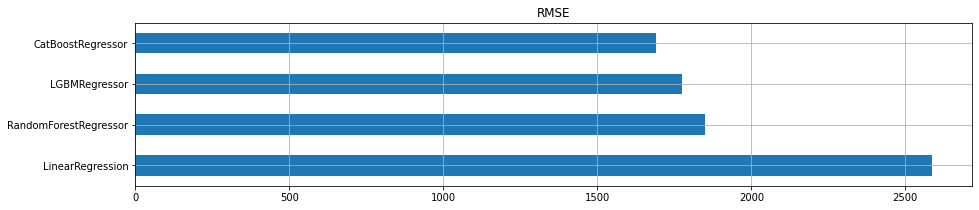

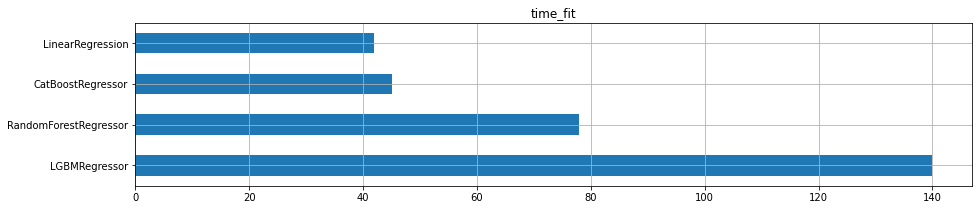

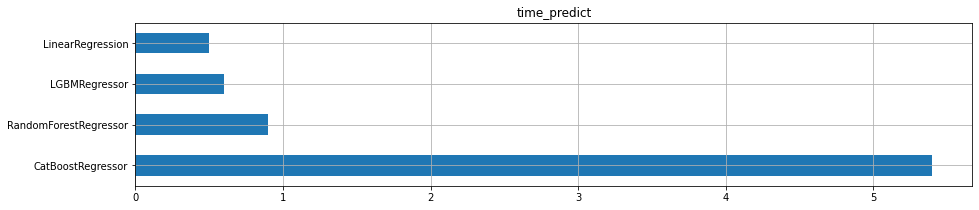

In [68]:
for c in final.columns:
    plt.title(c)
    final[c].sort_values(ascending=False).plot(kind='barh', figsize=(15,3), grid=True);
    plt.show()

Наилучшее качество у моделей CatBoostRegressor и LGBMRegressor, а наихудшее качество у модели LinearRegression (оно совсем не удовлетворяет требованиям заказчика).

Наилучшая скорость обучения у моделей LinearRegression и CatBoostRegressor, а наихудшая скорость обучения у модели LGBMRegressor.

Наилучшая скорость предсказания у модели LinearRegression и LGBMRegressor, а наихудшая скорость предсказания у модели CatBoostRegressor.

Для удовлетвроения условий заказчика рекомендуется использовать LGBMRegressor, так как у данной модели хорошее качество и хорошая скорость предсказания.